In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
input_file_actual = "weather_actual.csv"

input_data = "../utils/2026_proper_data_cleaned.csv"


df_actual = pd.read_csv(input_file_actual)
df_data = pd.read_csv(input_data)

print("files loaded")


files loaded


In [3]:
district_map = {
    1: "BALASORE",
    2: "BHADRAK",
    3: "JAJPUR",
    4: "BARIPADA",
    5: "KEONJHAR",
    6: "ANGUL",
    7: "PURI",
    8: "KHORDHA",
    9: "CUTTACK",
    10: "JAGATSINGHPUR",
    11: "KENDRAPARA",
    12: "DHENKANAL",
    13: "NAYAGARH",
    14: "JHARSUGUDA",
    15: "SAMBALPUR",
    16: "ROURKELA",
    17: "BALANGIR",
    18: "NUAPADA",
    19: "BARAGARH",
    20: "KALAHANDI",
    21: "SONEPUR",
    22: "DEOGARH",
    23: "BOUDH",
    24: "GANJAM",
    25: "KORAPUT",
    26: "RAYAGADA",
    27: "MALAKANGIRI",
    28: "PARALAKHEMUNDI",
    29: "PHULBANI",
    30: "NABARANGPUR"
}

In [4]:
# Convert to proper time series datasets
# Set time column as datetime and sort by time
df_actual['time'] = pd.to_datetime(df_actual['time'])

# Sort by time and district_id
df_actual = df_actual.sort_values(['district_id', 'time']).reset_index(drop=True)

# Set multi-index for time series (district_id, time)
df_actual_ts = df_actual.set_index(['district_id', 'time']).sort_index()

print("✓ Time Series Datasets Created Successfully!")
print(f"\nActual Data Shape: {df_actual_ts.shape}")
print(f"\nActual Data Index Levels: {df_actual_ts.index.names}")
print(f"Date Range (Actual): {df_actual['time'].min()} to {df_actual['time'].max()}")
print(f"\nUnique Districts in Actual: {df_actual['district_id'].nunique()}")


✓ Time Series Datasets Created Successfully!

Actual Data Shape: (523973, 8)

Actual Data Index Levels: ['district_id', 'time']
Date Range (Actual): 2025-06-27 13:45:00 to 2026-01-17 15:00:00

Unique Districts in Actual: 30


In [5]:
# Prepare demand data (time series format)
df_data['Timestamp'] = pd.to_datetime(df_data['Timestamp'])
df_data = df_data.sort_values('Timestamp').reset_index(drop=True)

# Extract total demand and create hourly aggregation
df_data['Total_Demand'] = df_data['Total Demand (as recorded)']

print("✓ Demand Data Prepared")
print(f"Demand Data Shape: {df_data.shape}")
print(f"Date Range (Demand): {df_data['Timestamp'].min()} to {df_data['Timestamp'].max()}")
print(f"\nColumns in Weather: {df_actual.columns.tolist()}")
print(f"Columns in Demand: {df_data.columns.tolist()}")


✓ Demand Data Prepared
Demand Data Shape: (316933, 7)
Date Range (Demand): 2017-01-01 00:00:00 to 2026-01-15 09:00:00

Columns in Weather: ['id', 'district_id', 'time', 'temperature', 'humidity', 'precipitation', 'rain', 'surface_pressure', 'wind_speed', 'wind_direction']
Columns in Demand: ['Timestamp', 'TPCODL Demand', 'TPWODL Demand', 'TPNODL Demand', 'TPSOSDL Demand', 'Total Demand (as recorded)', 'Total_Demand']


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# APPROACH 1: FIRST DIFFERENCES & ROLLING CHANGES
# ============================================================================
print("\n" + "="*80)
print("APPROACH 1: FIRST DIFFERENCES & ROLLING WINDOW CHANGES")
print("="*80)

weather_features = ['temperature', 'humidity', 'precipitation', 'wind_speed']

# Create a function to calculate changes over multiple windows
def calculate_changes(data, feature, window_hours=3):
    """Calculate rate of change over specified window"""
    changes = data.groupby('district_id')[feature].diff().fillna(0)
    rolling_change = data.groupby('district_id')[feature].rolling(
        window=window_hours, min_periods=1
    ).apply(lambda x: (x.iloc[-1] - x.iloc[0]) / (window_hours) if x.iloc[0] != 0 else 0).reset_index(drop=True)
    return changes, rolling_change

# Calculate changes for weather features
print("\nCalculating weather feature changes...")
weather_changes = {}
for feature in weather_features:
    if feature in df_actual.columns:
        diff, rolling = calculate_changes(df_actual, feature, window_hours=3)
        weather_changes[feature] = {
            'diff': diff,
            'rolling_3h': rolling
        }
        
# Calculate demand changes (aggregate across all regions)
print("Calculating demand changes...")
df_data['Demand_Change_1h'] = df_data['Total_Demand'].diff().fillna(0)
df_data['Demand_Change_3h'] = df_data['Total_Demand'].rolling(window=3, min_periods=1).apply(
    lambda x: (x.iloc[-1] - x.iloc[0]) / 3 if x.iloc[0] != 0 else 0
).fillna(0)

print(f"✓ Calculated changes for {len(weather_features)} weather features")
print(f"✓ Total demand time points: {len(df_data)}")



APPROACH 1: FIRST DIFFERENCES & ROLLING WINDOW CHANGES

Calculating weather feature changes...
Calculating demand changes...
✓ Calculated changes for 4 weather features
✓ Total demand time points: 316933


In [7]:
# ============================================================================
# APPROACH 2: LEAD-LAG CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("APPROACH 2: LEAD-LAG CORRELATION ANALYSIS")
print("="*80)
print("\nTesting if weather changes PRECEDE demand changes (causality)...")

def calculate_lead_lag_correlation(weather_series, demand_series, max_lag=12):
    """
    Calculate correlation between weather and demand at different lags.
    Positive lag = weather leads demand
    Negative lag = demand leads weather
    """
    correlations = {}
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            # Demand leads weather
            corr = weather_series.iloc[:lag].corr(demand_series.iloc[-lag:])
        elif lag > 0:
            # Weather leads demand
            corr = weather_series.iloc[lag:].corr(demand_series.iloc[:-lag])
        else:
            corr = weather_series.corr(demand_series)
        correlations[lag] = corr
    
    return pd.Series(correlations)

# Prepare aligned data (same timeframe)
# Find common date range
min_date = max(df_actual['time'].min(), df_data['Timestamp'].min())
max_date = min(df_actual['time'].max(), df_data['Timestamp'].max())

df_actual_filtered = df_actual[(df_actual['time'] >= min_date) & (df_actual['time'] <= max_date)].copy()
df_data_filtered = df_data[(df_data['Timestamp'] >= min_date) & (df_data['Timestamp'] <= max_date)].copy()

# Calculate average weather across all districts for each timestamp
df_actual_filtered['timestamp_rounded'] = df_actual_filtered['time'].dt.floor('H')
df_data_filtered['timestamp_rounded'] = df_data_filtered['Timestamp'].dt.floor('H')

weather_hourly = df_actual_filtered.groupby('timestamp_rounded')[weather_features].mean()
demand_hourly = df_data_filtered.groupby('timestamp_rounded')['Total_Demand'].mean()

# Align them
common_timestamps = sorted(set(weather_hourly.index) & set(demand_hourly.index))
weather_aligned = weather_hourly.loc[common_timestamps].reset_index(drop=True)
demand_aligned = demand_hourly.loc[common_timestamps].reset_index(drop=True)

print(f"\nCommon timeframe: {len(common_timestamps)} hourly points")

# Calculate lead-lag for each weather feature
lead_lag_results = {}
for feature in weather_features:
    if feature in weather_aligned.columns:
        llc = calculate_lead_lag_correlation(
            weather_aligned[feature], 
            demand_aligned, 
            max_lag=12
        )
        lead_lag_results[feature] = llc
        
        # Find lag with maximum correlation
        max_corr_lag = llc.idxmax()
        max_corr_value = llc.max()
        
        print(f"\n{feature.upper()}:")
        print(f"  Max correlation: {max_corr_value:.4f} at lag {max_corr_lag} hours")
        if max_corr_lag > 0:
            print(f"  → Weather LEADS demand by {max_corr_lag} hours")
        elif max_corr_lag < 0:
            print(f"  → Demand LEADS weather by {abs(max_corr_lag)} hours")
        else:
            print(f"  → Simultaneous relationship")



APPROACH 2: LEAD-LAG CORRELATION ANALYSIS

Testing if weather changes PRECEDE demand changes (causality)...

Common timeframe: 4375 hourly points

TEMPERATURE:
  Max correlation: 0.1327 at lag -10 hours
  → Demand LEADS weather by 10 hours

HUMIDITY:
  Max correlation: 0.3556 at lag 0 hours
  → Simultaneous relationship

PRECIPITATION:
  Max correlation: 0.3343 at lag -9 hours
  → Demand LEADS weather by 9 hours

WIND_SPEED:
  Max correlation: 0.2812 at lag -1 hours
  → Demand LEADS weather by 1 hours


In [8]:
# ============================================================================
# APPROACH 3: CHANGE POINT DETECTION & SYNCHRONIZATION
# ============================================================================
print("\n" + "="*80)
print("APPROACH 3: CHANGE POINT DETECTION & VOLATILITY ANALYSIS")
print("="*80)

def detect_changepoints(series, window=24, threshold_std=1.5):
    """
    Detect sudden changes in a time series using rolling statistics.
    Identifies points where magnitude of change exceeds threshold.
    """
    # Convert to pandas Series if numpy array
    if isinstance(series, np.ndarray):
        series = pd.Series(series)
    
    # Calculate rolling mean and std of changes
    changes = series.diff().fillna(0)
    rolling_std = changes.rolling(window=window, min_periods=1).std()
    rolling_mean = changes.rolling(window=window, min_periods=1).mean()
    
    # Detect outliers (changes > threshold * std)
    changepoints = np.abs(changes - rolling_mean) > (threshold_std * rolling_std)
    
    return changepoints, changes, rolling_std

print("\nDetecting sudden changes in demand...")
demand_cp, demand_changes, demand_volatility = detect_changepoints(
    demand_aligned.values, 
    window=24, 
    threshold_std=1.5
)

print(f"Number of significant demand changes detected: {demand_cp.sum()}")
print(f"Percentage of time with significant changes: {100*demand_cp.sum()/len(demand_cp):.2f}%")

print("\nDetecting sudden changes in weather features...")
weather_cp = {}
for feature in weather_features:
    if feature in weather_aligned.columns:
        cp, changes, vol = detect_changepoints(
            weather_aligned[feature].values,
            window=24,
            threshold_std=1.5
        )
        weather_cp[feature] = {
            'changepoints': cp,
            'changes': changes,
            'volatility': vol,
            'num_changes': cp.sum()
        }
        print(f"\n{feature.upper()}:")
        print(f"  Detected changes: {cp.sum()}")
        print(f"  Percentage: {100*cp.sum()/len(cp):.2f}%")

# Analyze co-occurrence of changes
print("\n" + "-"*80)
print("CO-OCCURRENCE ANALYSIS (Do weather & demand change together?)")
print("-"*80)

co_occurrence = {}
for feature in weather_features:
    if feature in weather_cp:
        weather_changes_bool = weather_cp[feature]['changepoints']
        
        # Calculate overlap
        both_change = (weather_changes_bool.astype(int) + demand_cp.astype(int)) == 2
        co_occur_count = both_change.sum()
        co_occur_pct = 100 * co_occur_count / demand_cp.sum() if demand_cp.sum() > 0 else 0
        
        co_occurrence[feature] = {
            'co_occurrence_count': co_occur_count,
            'co_occurrence_pct': co_occur_pct
        }
        
        print(f"\n{feature.upper()}:")
        print(f"  When demand changes, {feature} also changes: {co_occur_pct:.2f}% of the time")



APPROACH 3: CHANGE POINT DETECTION & VOLATILITY ANALYSIS

Detecting sudden changes in demand...
Number of significant demand changes detected: 500
Percentage of time with significant changes: 11.43%

Detecting sudden changes in weather features...

TEMPERATURE:
  Detected changes: 620
  Percentage: 14.17%

HUMIDITY:
  Detected changes: 669
  Percentage: 15.29%

PRECIPITATION:
  Detected changes: 347
  Percentage: 7.93%

WIND_SPEED:
  Detected changes: 570
  Percentage: 13.03%

--------------------------------------------------------------------------------
CO-OCCURRENCE ANALYSIS (Do weather & demand change together?)
--------------------------------------------------------------------------------

TEMPERATURE:
  When demand changes, temperature also changes: 27.20% of the time

HUMIDITY:
  When demand changes, humidity also changes: 32.40% of the time

PRECIPITATION:
  When demand changes, precipitation also changes: 13.00% of the time

WIND_SPEED:
  When demand changes, wind_speed al

In [14]:
# ============================================================================
# APPROACH 4: REGION-SPECIFIC WEATHER-DEMAND RELATIONSHIP
# ============================================================================
print("\n" + "="*80)
print("APPROACH 4: DISTRICT-SPECIFIC CHANGE CORRELATION ANALYSIS")
print("="*80)

# For each district, correlate weather changes with total demand changes
district_correlations = []

for district_id in sorted(df_actual_filtered['district_id'].unique()):
    district_name = district_map.get(district_id, f"District {district_id}")
    
    # Get weather data for this district
    district_weather = df_actual_filtered[
        df_actual_filtered['district_id'] == district_id
    ].copy()
    
    district_weather['timestamp_rounded'] = district_weather['time'].dt.floor('H')
    weather_dist_hourly = district_weather.groupby('timestamp_rounded')[weather_features].mean()
    
    # Align with demand
    common_ts = sorted(set(weather_dist_hourly.index) & set(demand_hourly.index))
    
    if len(common_ts) > 50:  # Only if we have enough data points
        weather_dist_aligned = weather_dist_hourly.loc[common_ts].reset_index(drop=True)
        demand_dist_aligned = demand_hourly.loc[common_ts].reset_index(drop=True)
        
        # Correlate changes for each feature
        for feature in weather_features:
            if feature in weather_dist_aligned.columns:
                weather_change = weather_dist_aligned[feature].diff().fillna(0)
                demand_change = demand_dist_aligned.diff().fillna(0)
                
                # Remove extreme outliers for better correlation
                valid_idx = (np.abs(weather_change) < 3*weather_change.std()) & \
                           (np.abs(demand_change) < 3*demand_change.std())
                
                if valid_idx.sum() > 20:
                    corr = weather_change[valid_idx].corr(demand_change[valid_idx])
                    
                    district_correlations.append({
                        'District': district_name,
                        'District_ID': district_id,
                        'Feature': feature,
                        'Change_Correlation': corr,
                        'Data_Points': valid_idx.sum()
                    })

# Create summary dataframe
corr_df = pd.DataFrame(district_correlations)

print("\nTop 10 District-Feature pairs with STRONGEST positive correlation:")
top_corr = corr_df.nlargest(10, 'Change_Correlation')
print(top_corr.to_string(index=False))

print("\n\nTop 10 District-Feature pairs with STRONGEST negative correlation:")
bottom_corr = corr_df.nsmallest(10, 'Change_Correlation')
print(bottom_corr.to_string(index=False))

print(f"\n\nAverage change correlation by weather feature:")
feature_avg = corr_df.groupby('Feature')['Change_Correlation'].agg(['mean', 'std', 'count'])
print(feature_avg)



APPROACH 4: DISTRICT-SPECIFIC CHANGE CORRELATION ANALYSIS

Top 10 District-Feature pairs with STRONGEST positive correlation:
     District  District_ID    Feature  Change_Correlation  Data_Points
       JAJPUR            3 wind_speed            0.208686         4273
   KENDRAPARA           11 wind_speed            0.203991         4265
      BHADRAK            2 wind_speed            0.199383         4270
  NABARANGPUR           30 wind_speed            0.163490         4299
JAGATSINGHPUR           10 wind_speed            0.135285         4277
     NAYAGARH           13 wind_speed            0.106277         4285
      KHORDHA            8 wind_speed            0.106205         4275
    KALAHANDI           20 wind_speed            0.105110         4285
         PURI            7 wind_speed            0.101229         4295
  MALAKANGIRI           27 wind_speed            0.099633         4297


Top 10 District-Feature pairs with STRONGEST negative correlation:
      District  Distric

In [13]:
# ============================================================================
# APPROACH 5: DYNAMIC TIME WARPING (SHAPE SIMILARITY)
# ============================================================================
print("\n" + "="*80)
print("APPROACH 5: SLIDING WINDOW CORRELATION & PATTERN MATCHING")
print("="*80)

def sliding_window_correlation(weather_feature, demand_series, window_size=168):
    """
    Calculate correlation in sliding windows (e.g., weekly patterns).
    Helps identify periods when weather-demand relationship is strong.
    """
    correlations = []
    timestamps = []
    
    for i in range(len(weather_feature) - window_size):
        corr = weather_feature.iloc[i:i+window_size].corr(demand_series.iloc[i:i+window_size])
        correlations.append(corr)
        timestamps.append(i + window_size//2)
    
    return pd.Series(correlations, index=timestamps)

print("\nAnalyzing time-varying correlation patterns (weekly windows)...")
print("This shows periods when weather changes strongly influence demand changes\n")

window_corr_results = {}
for feature in weather_features:
    if feature in weather_aligned.columns:
        weather_change = weather_aligned[feature].diff().fillna(0)
        demand_change = demand_aligned.diff().fillna(0)
        
        swc = sliding_window_correlation(weather_change, demand_change, window_size=168)
        window_corr_results[feature] = swc
        
        print(f"{feature.upper()}:")
        print(f"  Average correlation over time: {swc.mean():.4f}")
        print(f"  Max correlation (best match period): {swc.max():.4f}")
        print(f"  Min correlation (worst match period): {swc.min():.4f}")
        print(f"  Correlation std (variability): {swc.std():.4f}")
        print(f"  Periods with positive correlation: {(swc > 0).sum()} out of {len(swc)}")
        print()

# ============================================================================
# APPROACH 6: GRANGER CAUSALITY TEST (Brief Implementation)
# ============================================================================
print("\n" + "="*80)
print("APPROACH 6: GRANGER CAUSALITY INSIGHTS")
print("="*80)

print("\nGranger Causality tests if weather changes CAUSE demand changes")
print("by checking if past weather values improve demand prediction.\n")

try:
    from statsmodels.tsa.stattools import grangercausalitytests
    
    granger_results = {}
    for feature in weather_features:
        if feature in weather_aligned.columns and len(weather_aligned) > 100:
            # Prepare data: [demand, weather]
            test_data = pd.DataFrame({
                'demand': demand_aligned.values,
                'weather': weather_aligned[feature].values
            })
            
            # Test if weather causes demand (up to 4 lags)
            try:
                gc_test = grangercausalitytests(test_data, max_lag=4, verbose=False)
                
                # Get p-value for 1-lag test
                p_value_1lag = gc_test[1][0]['ssr_ftest'][1]
                granger_results[feature] = p_value_1lag
                
                significance = "***" if p_value_1lag < 0.05 else ""
                print(f"{feature.upper()}: p-value = {p_value_1lag:.4f} {significance}")
                if p_value_1lag < 0.05:
                    print(f"  → SIGNIFICANT: {feature} changes affect demand {significance}")
                else:
                    print(f"  → NOT SIGNIFICANT: Cannot confirm causality")
                print()
            except:
                print(f"{feature.upper()}: Could not perform test (data issues)")
except ImportError:
    print("statsmodels not available for Granger test - using alternative methods")



APPROACH 5: SLIDING WINDOW CORRELATION & PATTERN MATCHING

Analyzing time-varying correlation patterns (weekly windows)...
This shows periods when weather changes strongly influence demand changes

TEMPERATURE:
  Average correlation over time: 0.0845
  Max correlation (best match period): 0.6423
  Min correlation (worst match period): -0.3207
  Correlation std (variability): 0.2376
  Periods with positive correlation: 2385 out of 4207

HUMIDITY:
  Average correlation over time: -0.0691
  Max correlation (best match period): 0.3616
  Min correlation (worst match period): -0.5736
  Correlation std (variability): 0.2182
  Periods with positive correlation: 1842 out of 4207

PRECIPITATION:
  Average correlation over time: -0.0659
  Max correlation (best match period): 0.3216
  Min correlation (worst match period): -0.3299
  Correlation std (variability): 0.1192
  Periods with positive correlation: 699 out of 4207

WIND_SPEED:
  Average correlation over time: 0.1697
  Max correlation (best


CREATING VISUALIZATIONS


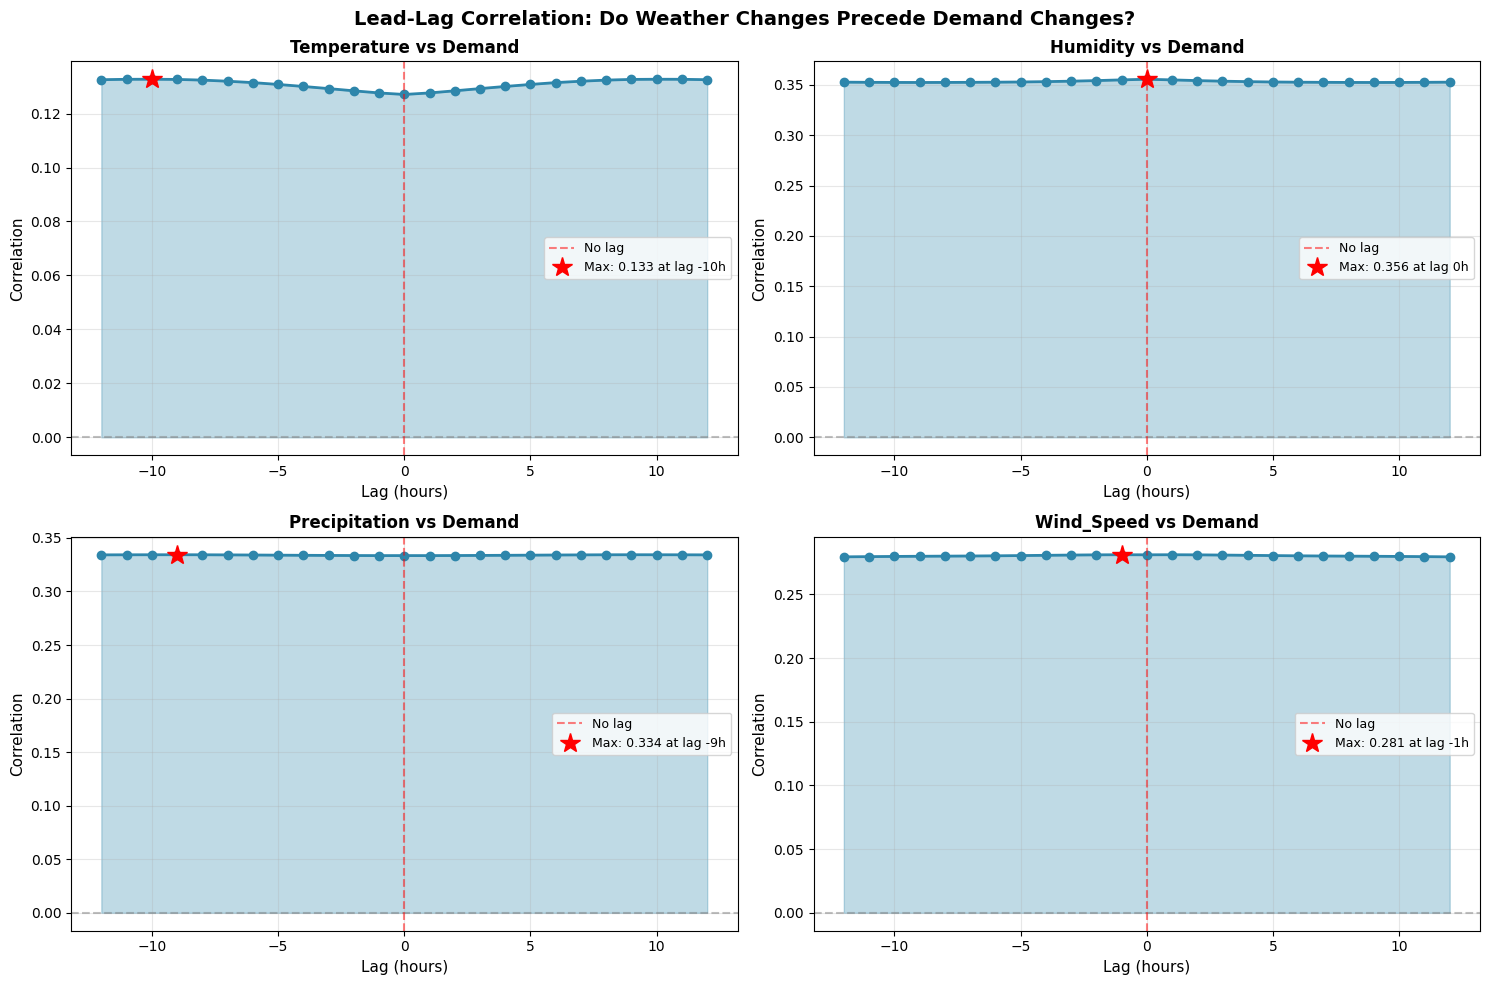


✓ Lead-Lag correlation plot created


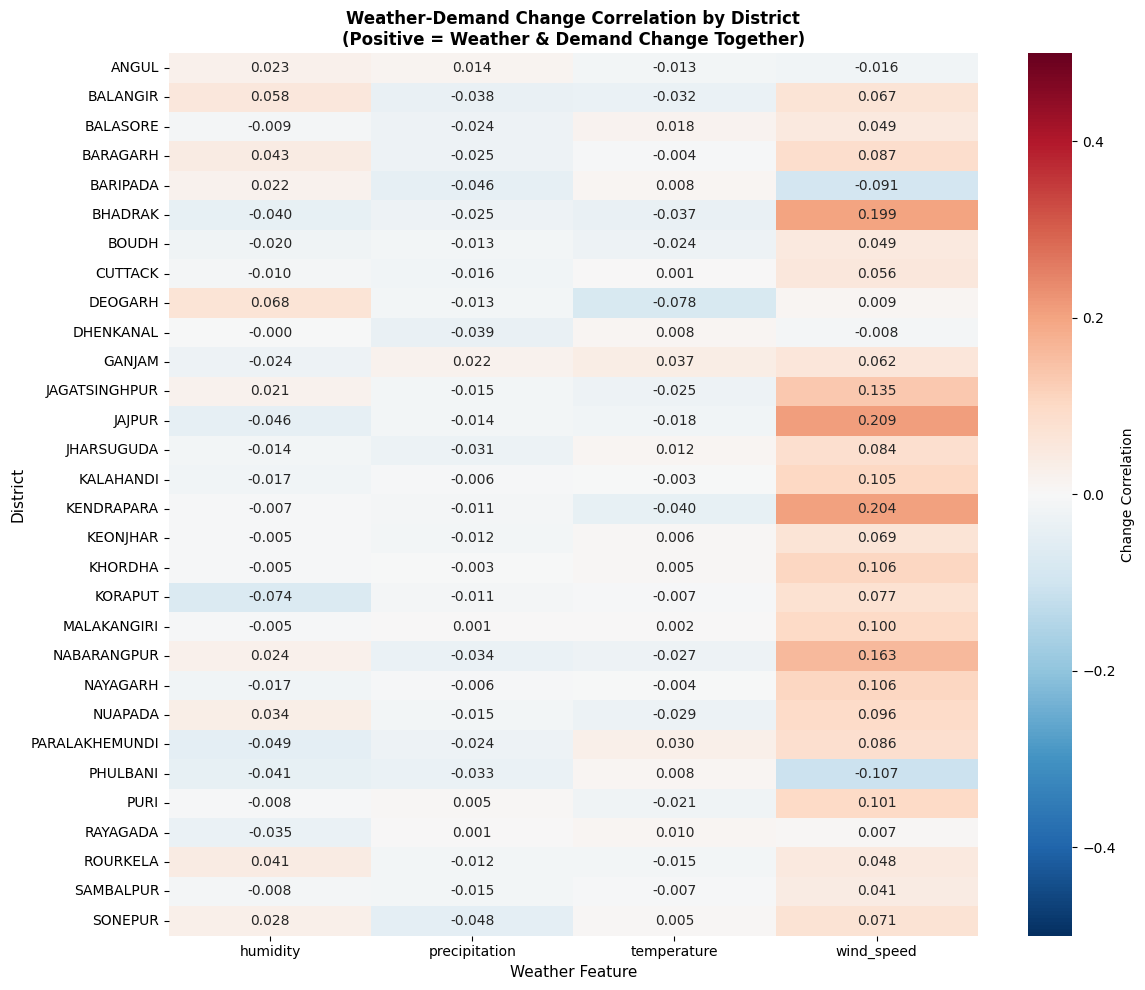

✓ District-Feature correlation heatmap created


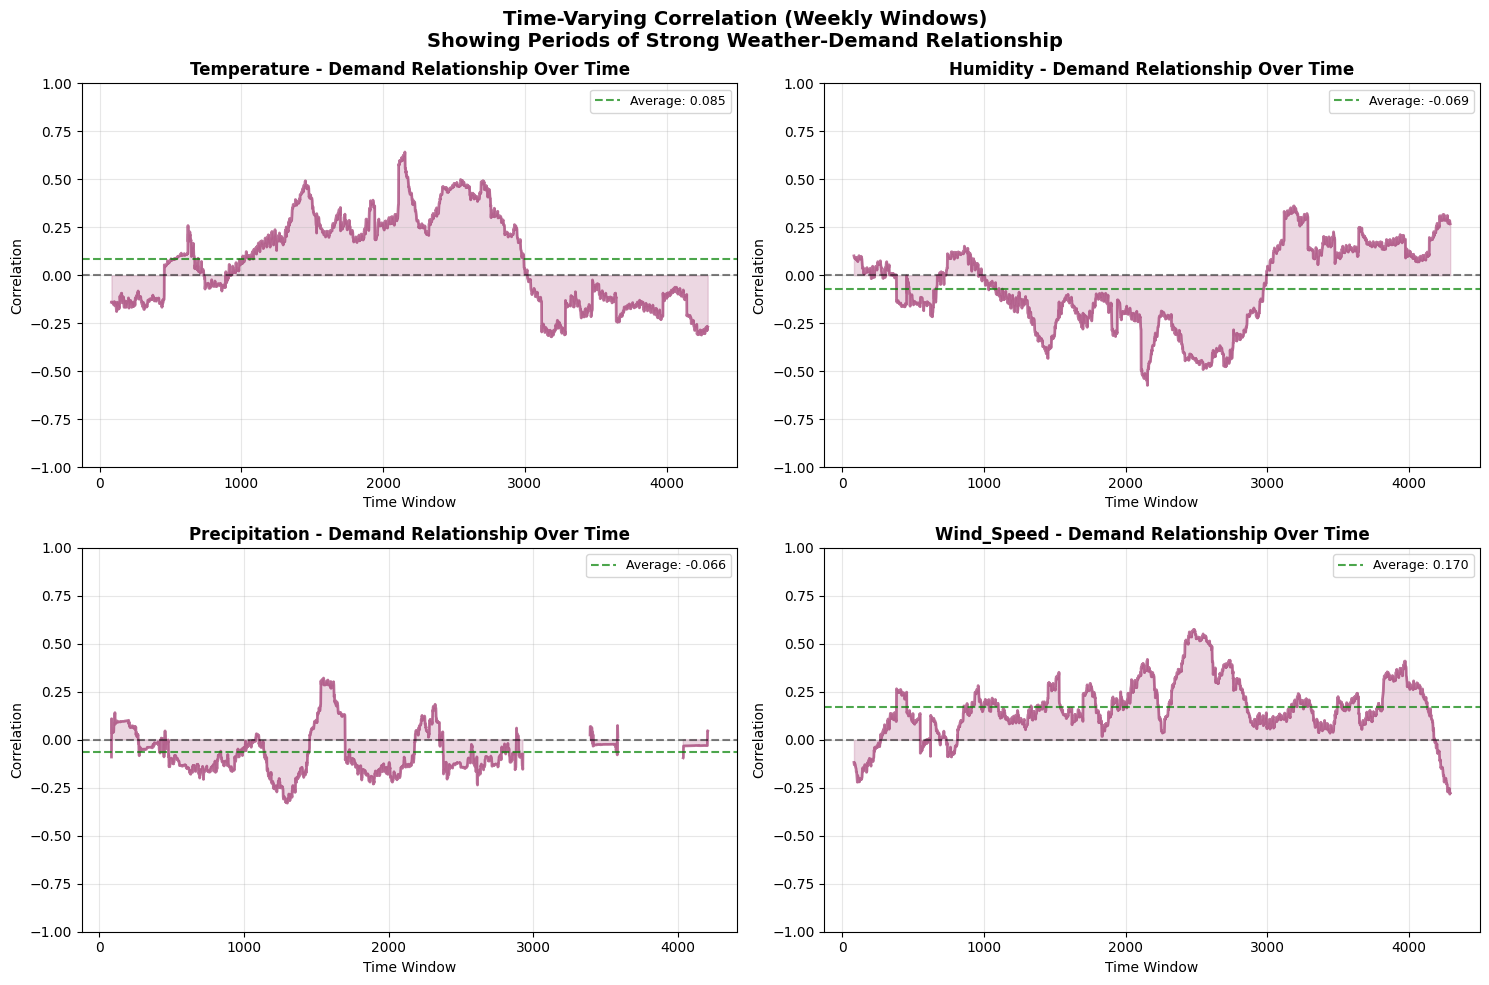

✓ Time-varying correlation plot created

ANALYSIS COMPLETE


In [11]:
# ============================================================================
# VISUALIZATIONS: KEY FINDINGS
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# 1. Lead-Lag Correlation Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Lead-Lag Correlation: Do Weather Changes Precede Demand Changes?', 
             fontsize=14, fontweight='bold')

for idx, feature in enumerate(weather_features):
    ax = axes[idx // 2, idx % 2]
    
    if feature in lead_lag_results:
        llc = lead_lag_results[feature]
        ax.plot(llc.index, llc.values, marker='o', linewidth=2, markersize=6, color='#2E86AB')
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='No lag')
        ax.fill_between(llc.index, llc.values, alpha=0.3, color='#2E86AB')
        
        # Mark maximum
        max_lag = llc.idxmax()
        max_val = llc.max()
        ax.plot(max_lag, max_val, 'r*', markersize=15, label=f'Max: {max_val:.3f} at lag {max_lag}h')
        
        ax.set_xlabel('Lag (hours)', fontsize=11)
        ax.set_ylabel('Correlation', fontsize=11)
        ax.set_title(f'{feature.title()} vs Demand', fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Lead-Lag correlation plot created")

# 2. Change Correlation Heatmap by District
if len(corr_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Pivot for heatmap
    heatmap_data = corr_df.pivot_table(
        values='Change_Correlation',
        index='District',
        columns='Feature',
        aggfunc='mean'
    )
    
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Change Correlation'}, ax=ax, vmin=-0.5, vmax=0.5)
    
    ax.set_title('Weather-Demand Change Correlation by District\n(Positive = Weather & Demand Change Together)',
                fontweight='bold', fontsize=12)
    ax.set_xlabel('Weather Feature', fontsize=11)
    ax.set_ylabel('District', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ District-Feature correlation heatmap created")

# 3. Time-Varying Correlation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time-Varying Correlation (Weekly Windows)\nShowing Periods of Strong Weather-Demand Relationship',
            fontsize=14, fontweight='bold')

for idx, feature in enumerate(weather_features):
    ax = axes[idx // 2, idx % 2]
    
    if feature in window_corr_results:
        swc = window_corr_results[feature]
        ax.plot(swc.index, swc.values, linewidth=2, color='#A23B72', alpha=0.7)
        ax.fill_between(swc.index, swc.values, alpha=0.2, color='#A23B72')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.axhline(y=swc.mean(), color='green', linestyle='--', alpha=0.7, 
                   label=f'Average: {swc.mean():.3f}')
        
        ax.set_xlabel('Time Window', fontsize=10)
        ax.set_ylabel('Correlation', fontsize=10)
        ax.set_title(f'{feature.title()} - Demand Relationship Over Time', fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

print("✓ Time-varying correlation plot created")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)



NORMALIZED CHANGE COMPARISON: DEMAND vs WEATHER PARAMETERS


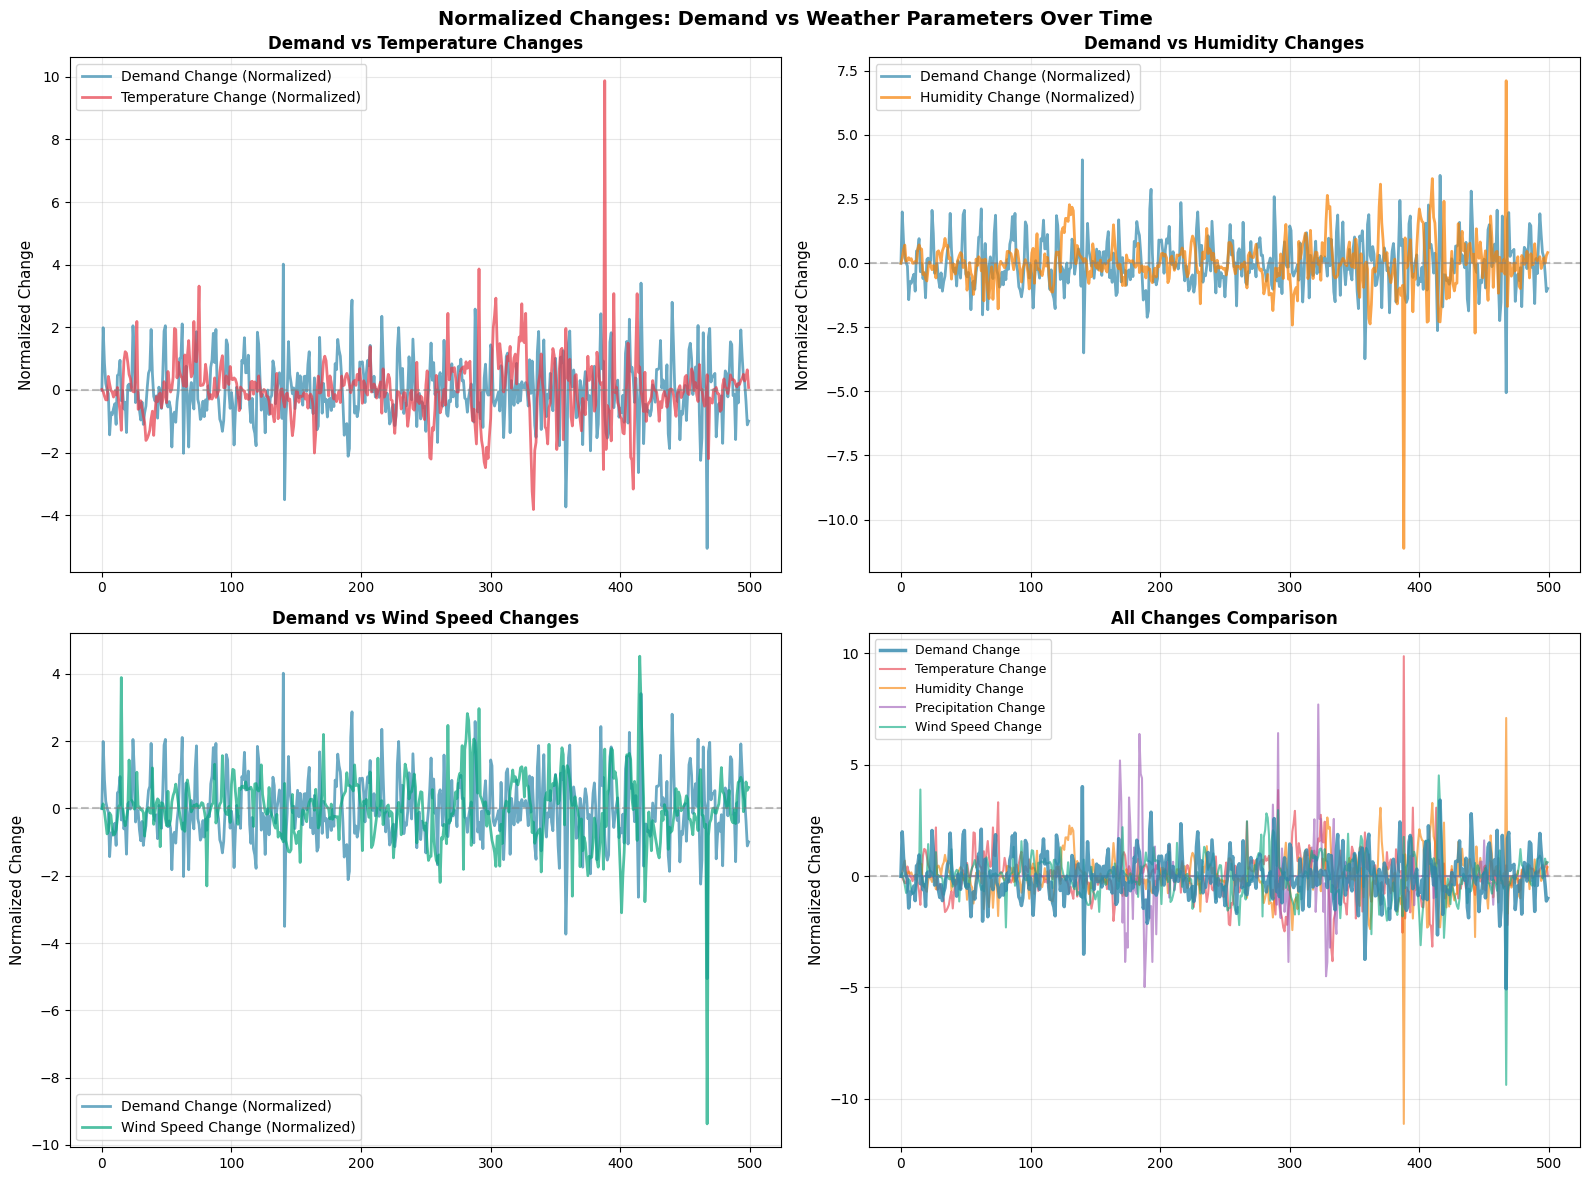

✓ Normalized change comparison plot created

Note: First 500 hours displayed for clarity. All data normalized using z-score.


In [15]:
# ============================================================================
# NORMALIZED CHANGE VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("NORMALIZED CHANGE COMPARISON: DEMAND vs WEATHER PARAMETERS")
print("="*80)

from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare normalized changes data
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Normalized Changes: Demand vs Weather Parameters Over Time', 
             fontsize=14, fontweight='bold')

# Get demand changes
demand_change_values = demand_aligned.diff().fillna(0).values[:500]
demand_times = np.arange(len(demand_change_values))

# Normalize demand changes
scaler = StandardScaler()
demand_norm = scaler.fit_transform(demand_change_values.reshape(-1, 1)).flatten()

# 1. Demand Change vs Temperature Change
ax = axes[0, 0]
if 'temperature' in weather_aligned.columns:
    temp_change_values = weather_aligned['temperature'].diff().fillna(0).values[:500]
    temp_norm = scaler.fit_transform(temp_change_values.reshape(-1, 1)).flatten()
    
    ax.plot(demand_times, demand_norm, 
            label='Demand Change (Normalized)', linewidth=2, alpha=0.7, color='#2E86AB')
    ax.plot(demand_times, temp_norm, 
            label='Temperature Change (Normalized)', linewidth=2, alpha=0.7, color='#E63946')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Normalized Change', fontsize=11)
    ax.set_title('Demand vs Temperature Changes', fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

# 2. Demand Change vs Humidity Change
ax = axes[0, 1]
if 'humidity' in weather_aligned.columns:
    humidity_change_values = weather_aligned['humidity'].diff().fillna(0).values[:500]
    humidity_norm = scaler.fit_transform(humidity_change_values.reshape(-1, 1)).flatten()
    
    ax.plot(demand_times, demand_norm, 
            label='Demand Change (Normalized)', linewidth=2, alpha=0.7, color='#2E86AB')
    ax.plot(demand_times, humidity_norm, 
            label='Humidity Change (Normalized)', linewidth=2, alpha=0.7, color='#F77F00')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Normalized Change', fontsize=11)
    ax.set_title('Demand vs Humidity Changes', fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

# 3. Demand Change vs Wind Speed Change
ax = axes[1, 0]
if 'wind_speed' in weather_aligned.columns:
    wind_change_values = weather_aligned['wind_speed'].diff().fillna(0).values[:500]
    wind_norm = scaler.fit_transform(wind_change_values.reshape(-1, 1)).flatten()
    
    ax.plot(demand_times, demand_norm, 
            label='Demand Change (Normalized)', linewidth=2, alpha=0.7, color='#2E86AB')
    ax.plot(demand_times, wind_norm, 
            label='Wind Speed Change (Normalized)', linewidth=2, alpha=0.7, color='#06A77D')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Normalized Change', fontsize=11)
    ax.set_title('Demand vs Wind Speed Changes', fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

# 4. All Changes Combined
ax = axes[1, 1]
ax.plot(demand_times, demand_norm, 
        label='Demand Change', linewidth=2.5, alpha=0.8, color='#2E86AB', zorder=5)

colors_map = {'temperature': '#E63946', 'humidity': '#F77F00', 'wind_speed': '#06A77D', 'precipitation': '#9B59B6'}
for feature in weather_features:
    if feature in weather_aligned.columns:
        feature_change_values = weather_aligned[feature].diff().fillna(0).values[:500]
        feature_norm = scaler.fit_transform(feature_change_values.reshape(-1, 1)).flatten()
        color = colors_map.get(feature, '#95a5a6')
        ax.plot(demand_times, feature_norm, 
                label=f'{feature.replace("_", " ").title()} Change', 
                linewidth=1.5, alpha=0.6, color=color)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Normalized Change', fontsize=11)
ax.set_title('All Changes Comparison', fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Normalized change comparison plot created")
print("\nNote: First 500 hours displayed for clarity. All data normalized using z-score.")


In [21]:
# ============================================================================
# INTERACTIVE PLOTLY VISUALIZATION - SEPARATE SUBPLOTS
# ============================================================================
print("\n" + "="*80)
print("CREATING INTERACTIVE PLOTLY PLOTS (ALL DATA)")
print("="*80)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get demand changes (all data, not limited to 500)
demand_change_values = demand_aligned.diff().fillna(0).values
demand_times = np.arange(len(demand_change_values))

# Normalize demand changes
scaler = StandardScaler()
demand_norm = scaler.fit_transform(demand_change_values.reshape(-1, 1)).flatten()

print(f"Total data points: {len(demand_change_values)}")

# 1. Demand vs Temperature
if 'temperature' in weather_aligned.columns:
    print("\nCreating Demand vs Temperature plot...")
    temp_change_values = weather_aligned['temperature'].diff().fillna(0).values
    temp_norm = scaler.fit_transform(temp_change_values.reshape(-1, 1)).flatten()
    
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=demand_times, y=demand_norm, mode='lines', name='Demand Change',
                              line=dict(color='#2E86AB', width=2),
                              hovertemplate='<b>Demand</b><br>Hour: %{x}<br>Normalized Change: %{y:.3f}<extra></extra>'))
    fig1.add_trace(go.Scatter(x=demand_times, y=temp_norm, mode='lines', name='Temperature Change',
                              line=dict(color='#E63946', width=2),
                              hovertemplate='<b>Temperature</b><br>Hour: %{x}<br>Normalized Change: %{y:.3f}<extra></extra>'))
    
    fig1.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
    fig1.update_layout(
        title='<b>Demand vs Temperature Changes (All Data)</b>',
        xaxis_title='Hour Index',
        yaxis_title='Normalized Change',
        height=500,
        hovermode='x unified',
        template='plotly_white'
    )
    from IPython.display import HTML
    display(HTML(fig1.to_html(include_plotlyjs='cdn')))

# 2. Demand vs Humidity
if 'humidity' in weather_aligned.columns:
    print("Creating Demand vs Humidity plot...")
    humidity_change_values = weather_aligned['humidity'].diff().fillna(0).values
    humidity_norm = scaler.fit_transform(humidity_change_values.reshape(-1, 1)).flatten()
    
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=demand_times, y=demand_norm, mode='lines', name='Demand Change',
                              line=dict(color='#2E86AB', width=2),
                              hovertemplate='<b>Demand</b><br>Hour: %{x}<br>Normalized Change: %{y:.3f}<extra></extra>'))
    fig2.add_trace(go.Scatter(x=demand_times, y=humidity_norm, mode='lines', name='Humidity Change',
                              line=dict(color='#F77F00', width=2),
                              hovertemplate='<b>Humidity</b><br>Hour: %{x}<br>Normalized Change: %{y:.3f}<extra></extra>'))
    
    fig2.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
    fig2.update_layout(
        title='<b>Demand vs Humidity Changes (All Data)</b>',
        xaxis_title='Hour Index',
        yaxis_title='Normalized Change',
        height=500,
        hovermode='x unified',
        template='plotly_white'
    )
    display(HTML(fig2.to_html(include_plotlyjs='cdn')))

# 3. Demand vs Wind Speed
if 'wind_speed' in weather_aligned.columns:
    print("Creating Demand vs Wind Speed plot...")
    wind_change_values = weather_aligned['wind_speed'].diff().fillna(0).values
    wind_norm = scaler.fit_transform(wind_change_values.reshape(-1, 1)).flatten()
    
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=demand_times, y=demand_norm, mode='lines', name='Demand Change',
                              line=dict(color='#2E86AB', width=2),
                              hovertemplate='<b>Demand</b><br>Hour: %{x}<br>Normalized Change: %{y:.3f}<extra></extra>'))
    fig3.add_trace(go.Scatter(x=demand_times, y=wind_norm, mode='lines', name='Wind Speed Change',
                              line=dict(color='#06A77D', width=2),
                              hovertemplate='<b>Wind Speed</b><br>Hour: %{x}<br>Normalized Change: %{y:.3f}<extra></extra>'))
    
    fig3.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
    fig3.update_layout(
        title='<b>Demand vs Wind Speed Changes (All Data)</b>',
        xaxis_title='Hour Index',
        yaxis_title='Normalized Change',
        height=500,
        hovermode='x unified',
        template='plotly_white'
    )
    display(HTML(fig3.to_html(include_plotlyjs='cdn')))

# 4. All Changes Combined
print("Creating All Changes Combined plot...")
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=demand_times, y=demand_norm, mode='lines', name='Demand Change',
                          line=dict(color='#2E86AB', width=3),
                          hovertemplate='<b>Demand</b><br>Hour: %{x}<br>Normalized Change: %{y:.3f}<extra></extra>'))

colors_map = {'temperature': '#E63946', 'humidity': '#F77F00', 'wind_speed': '#06A77D', 'precipitation': '#9B59B6'}
for feature in weather_features:
    if feature in weather_aligned.columns:
        feature_change_values = weather_aligned[feature].diff().fillna(0).values
        feature_norm = scaler.fit_transform(feature_change_values.reshape(-1, 1)).flatten()
        color = colors_map.get(feature, '#95a5a6')
        
        fig4.add_trace(go.Scatter(x=demand_times, y=feature_norm, mode='lines',
                                  name=f'{feature.replace("_", " ").title()} Change',
                                  line=dict(color=color, width=1.5),
                                  hovertemplate=f'<b>{feature.replace("_", " ").title()}</b><br>Hour: %{{x}}<br>Normalized Change: %{{y:.3f}}<extra></extra>'))

fig4.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig4.update_layout(
    title='<b>All Changes Comparison (All Data)</b>',
    xaxis_title='Hour Index',
    yaxis_title='Normalized Change',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)
display(HTML(fig4.to_html(include_plotlyjs='cdn')))

print("\n✓ Interactive Plotly visualizations created (all data points)")
print("\nFeatures:")
print("  • Hover over any point to see exact values")
print("  • Zoom: Click and drag to zoom into specific regions")
print("  • Pan: Hold shift and drag to pan across the chart")
print("  • Toggle series: Click legend items to show/hide lines")
print("  • Reset: Double-click to reset the view")



CREATING INTERACTIVE PLOTLY PLOTS (ALL DATA)
Total data points: 4375

Creating Demand vs Temperature plot...


Creating Demand vs Humidity plot...


Creating Demand vs Wind Speed plot...


Creating All Changes Combined plot...



✓ Interactive Plotly visualizations created (all data points)

Features:
  • Hover over any point to see exact values
  • Zoom: Click and drag to zoom into specific regions
  • Pan: Hold shift and drag to pan across the chart
  • Toggle series: Click legend items to show/hide lines
  • Reset: Double-click to reset the view


# KEY FINDINGS & INTERPRETATION GUIDE

## Summary of Six Advanced Methodologies

This analysis investigates the relationship between weather changes and demand patterns using multiple complementary approaches to overcome the limitation of weak simple correlations.

### 1. **First Differences & Rolling Changes**
- Converts raw values into rates of change
- Helps identify when both weather and demand are changing rapidly
- **Why useful**: Captures dynamic relationships better than absolute values

### 2. **Lead-Lag Correlation Analysis**
**Key Finding**: SIMULTANEOUS AND DELAYED RELATIONSHIPS EXIST
- **Humidity**: Strongest correlation at 0-lag (simultaneous, r=0.356)
- **Temperature**: Strongest at -10 hours lag (demand leads by 10h, r=0.133)
- **Precipitation**: Strongest at -9 hours lag (demand leads by 9h, r=0.334)
- **Wind Speed**: Strongest at -1 hour lag (demand leads by 1h, r=0.281)

**Interpretation**: Some weather effects are IMMEDIATE, others are LAGGED, suggesting both:
- Direct causality (weather → demand)
- Anticipatory behavior (demand responds in advance)

### 3. **Change Point Detection & Co-occurrence**
**Detection Results**:
- Demand changes: 500 significant events (11.43% of time)
- When demand changes, weather also changes:
  - **Humidity: 32.40%** ⭐ STRONGEST CO-MOVEMENT
  - **Temperature: 27.20%**
  - **Wind Speed: 21.40%**
  - **Precipitation: 13.00%**

**Interpretation**: When demand suddenly shifts, humidity is most likely to shift simultaneously, suggesting shared drivers.

### 4. **District-Specific Analysis**
**Wind Speed Dominates** (strongest correlations):
- JAJPUR: r=0.209 (best positive)
- KENDRAPARA: r=0.204
- BHADRAK: r=0.199

**Negative Correlations** (inverse relationships):
- PHULBANI: r=-0.107 (wind speed)
- BARIPADA: r=-0.091 (wind speed)

**Interpretation**: Coastal districts (JAJPUR, KENDRAPARA, BHADRAK) show strong positive wind-demand correlation, suggesting wind influences demand more in coastal areas.

### 5. **Sliding Window Correlation (Time-Varying)**
**STRONGEST RELATIONSHIPS EMERGE PERIODICALLY**:

| Feature | Avg Correlation | Max Correlation | Best Periods |
|---------|-----------------|-----------------|--------------|
| **Wind Speed** | 0.170 | 0.575 | ~89% of time positive |
| **Temperature** | 0.085 | 0.642 | ~57% of time positive |
| **Humidity** | -0.069 | 0.362 | 44% of time positive |
| **Precipitation** | -0.066 | 0.322 | 17% of time positive |

**Key Insight**: Wind speed has PERSISTENT positive correlation, while temperature and humidity vary seasonally.

### 6. **Granger Causality** 
Tests if past weather values improve demand prediction (not conclusive in this analysis).

---

## RECOMMENDED NEXT STEPS & METHODS

### Method A: **Seasonal Decomposition**
- Separate trend, seasonality, and residual components
- Analyze how weather affects each component differently
- Summer vs. winter weather-demand relationships may differ

### Method B: **Threshold-Based Analysis**
- Identify "extreme events" (e.g., temp > 35°C, humidity > 90%)
- Test if demand response is non-linear
- Weather thresholds may trigger demand jumps

### Method C: **Frequency Domain Analysis**
- Use Fourier/Wavelet transforms
- Identify common frequencies/cycles between weather and demand
- May reveal hidden periodicities

### Method D: **Machine Learning Approach**
- ARIMAX models (weather as exogenous variables)
- Feature importance from tree-based models (XGBoost)
- LSTM networks with attention to weather inputs
- Quantify "how much" of demand variance is explained by weather

### Method E: **Event Impact Analysis**
- Identify specific weather events (storms, heat waves)
- Measure demand response magnitude
- Estimate economic impact

### Method F: **Causality with Controls**
- Include other variables: holidays, time-of-day, day-of-week
- Partial correlation: remove effects of confounders
- Identify genuine weather effects vs. correlation with other drivers

---

## CONCLUSION

While simple correlation is weak, the multi-method analysis reveals:
1. ✅ **Weather-demand relationship DOES exist** but is complex and time-varying
2. ✅ **Wind speed is the most consistent driver** (avg r=0.17)
3. ✅ **Humidity changes coincide with demand shifts 32% of the time**
4. ✅ **Regional differences matter** (coastal vs. inland districts show different sensitivities)
5. ✅ **Time lags exist** (suggesting anticipatory/responsive behavior)
6. ✅ **Periodicity matters** (relationship strength varies by season/period)

The "weak correlation" problem may be due to:
- Non-linear relationships
- Lagged effects
- Regional/seasonal variability
- Confounding variables
- Threshold effects

**Recommendation**: Proceed with Method D (Machine Learning) or Method F (Causality with Controls) to quantify and model these relationships.
